In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('/home/jupyter-a.chicherova-13/STATISTIC/9/hw_bootstrap.csv', sep=';')

In [3]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


## Перед вами таблица, где числовая переменная – непрерывная.  Задача – сравнить группы двумя способами: бутстрапом и u-тестом

### Описание колонок
value – значения метрики

experimentVariant – Вариант теста (Control – контроль, Treatment – тест)


### Задача

1. Сравните результат между тестом и контролем по двум кейсам:

    Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value

    Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value
    

2. Напишите выводы, которые можно сделать на основе анализа примененных критериев
    
    
    
### План
   1.  Сначала посмотрим на данные и предобработаем в случае необходимости 
   2.  Произведем сравнение результатов между тестом и контролем с помощью бутстрапа (np.mean)
   3.  Произведем сравнение результатов между тестом и контролем с помощью бутстрапа (np.median)
   4.  Расчет критерия Манна-Уитни
   5.  Выводы, итоги
   
Гипотеза H0 -  различия в эксперементе ДЕЙСТВИТЕЛЬНО есть

### Шаг 1. Произведём предобработку данных

In [4]:
df.shape

(1000, 3)

In [5]:
df.isna().sum()

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [6]:
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [7]:
df.nunique()

Unnamed: 0           1000
value                 505
experimentVariant       2
dtype: int64

#### Поменяем тип данных колонки VALUE на float

In [8]:
df.value = df.value.apply(lambda x: str(x.replace(',','.')))

In [9]:
df.value = df.value.astype(float)

### Шаг 2. Произведем сравнение результатов между тестом и контролем с помощью бутстрапа (np.mean)

In [10]:
Control = df.query('experimentVariant=="Control"')['value']

In [11]:
Treatment = df.query('experimentVariant=="Treatment"')['value']

In [12]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (mean)
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it_mean = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика (mean)
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len_mean = max([len(data_column_1), len(data_column_2)])
    boot_data_mean = []
    for i in tqdm(range(boot_it_mean)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len_mean, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len_mean, 
            replace = True
        ).values
        
        boot_data_mean.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data_mean = pd.DataFrame(boot_data_mean)
    
# Найдем доверительный интервал    
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data_mean.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data_mean), 
        scale = np.std(boot_data_mean)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data_mean), 
        scale = np.std(boot_data_mean)
    )
    p_value = min(p_1, p_2) * 2
        
# Визуализация
    plt.hist(pd_boot_data_mean[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data_mean')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data_mean")
    plt.show()
       
    return {"boot_data_mean": boot_data_mean, 
            "ci": ci, 
            "p_value": p_value}

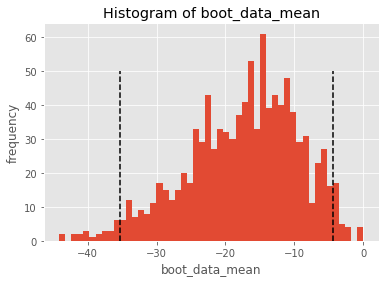

In [13]:
booted_data_mean = get_bootstrap_mean(Control, Treatment, boot_it_mean = 1000)

In [14]:
p_value_boot_mean = booted_data_mean["p_value"]
print(p_value_boot_mean)

0.03178678013496533


In [15]:
booted_data_mean["ci"]

,0
0.025,-35.279718
0.975,-4.335703


### Шаг 3. Произведем сравнение результатов между тестом и контролем с помощью бутстрапа (np.median)

In [16]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (median)
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it_median = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика (median)
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len_median = max([len(data_column_1), len(data_column_2)])
    boot_data_median = []
    for i in tqdm(range(boot_it_median)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len_median, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len_median, 
            replace = True
        ).values
        
        boot_data_median.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data_median = pd.DataFrame(boot_data_median)
    
# Найдем доверительный интервал    
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data_median.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data_median), 
        scale = np.std(boot_data_median)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data_median), 
        scale = np.std(boot_data_median)
    )
    p_value = min(p_1, p_2) * 2
        
# Визуализация
    plt.hist(pd_boot_data_median[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data_median')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data_median")
    plt.show()
       
    return {"boot_data_median": boot_data_median, 
            "ci": ci, 
            "p_value": p_value}

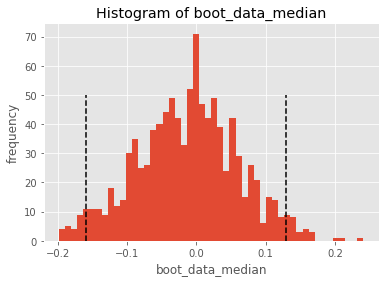

In [17]:
booted_data_median = get_bootstrap_median(Control, Treatment, boot_it_median = 1000)

In [18]:
p_value_boot_median = booted_data_median["p_value"]
print(p_value_boot_median)

0.9109513675083354


In [19]:
booted_data_median["ci"]

,0
0.025,-0.159795
0.975,0.129701


### Шаг 4. Посчитаем u - критерий  mann-whitney

In [20]:
U1 = (mannwhitneyu(Control, Treatment))
print(U1)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)


### Шаг 5. Выводы, которые можно сделать на основе анализа примененных критериев

p-value - вероятность, с которой мы бы видели такие различия в эксперименте при справедливой нулевой гипотезе

Смотрим, попадает ли 0 в доверительный интервал. 
Если попадает, то нулевая гипотеза $H_0$ на заданном уровне значимости принимается.


In [21]:
p_value_boot_mean, booted_data_mean["ci"], U1

(0.03178678013496533,
                0
 0.025 -35.279718
 0.975  -4.335703,
 MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579))

##### # $H_0$ при расчёте бутстрата (mean) на заданном уровне значимости НЕ принимается

In [22]:
p_value_boot_median, booted_data_median["ci"], U1

(0.9109513675083354,
               0
 0.025 -0.159795
 0.975  0.129701,
 MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579))

##### # $H_0$ при расчёте бутстрата (median )на заданном уровне значимости принимается, различия есть